In [3]:
# ============================================================================
# 02_FEATURE_ENGINEERING.IPYNB
# Ingeniería de Características para Agricultura Vertical
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

print("="*60)
print("INGENIERIA DE CARACTERISTICAS - AGRICULTURA VERTICAL")
print("="*60)

INGENIERIA DE CARACTERISTICAS - AGRICULTURA VERTICAL


1. CARGA DE DATOS PROCESADOS

In [4]:
# ============================================================================
# 1. CARGA DE DATOS PROCESADOS
# ============================================================================

print("\n1. CARGANDO DATOS PROCESADOS...")

# Cargar datos procesados
df = pd.read_csv('../data/processed/dataset_processed.csv')
train_data = pd.read_csv('../data/processed/train_data.csv')
val_data = pd.read_csv('../data/processed/validation_data.csv')
test_data = pd.read_csv('../data/processed/test_data.csv')

# Cargar metadata
import json
with open('../data/processed/preprocessing_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"Dataset completo: {df.shape}")
print(f"Entrenamiento: {train_data.shape}")
print(f"Validacion: {val_data.shape}")
print(f"Test: {test_data.shape}")

# Features base identificadas
base_features = metadata['feature_columns_eficiencia']
print(f"\nFeatures base: {len(base_features)}")
print(base_features)


1. CARGANDO DATOS PROCESADOS...
Dataset completo: (50000, 32)
Entrenamiento: (30000, 31)
Validacion: (10000, 31)
Test: (10000, 31)

Features base: 29
['hora_dia', 'dia_semana', 'estacion', 'temperatura_c', 'humedad_rel_pct', 'co2_ppm', 'vpd_kpa', 'pm2_5_ugm3', 'pm10_ugm3', 'vocs_mgm3', 'no2_ugm3', 'o3_ugm3', 'aqi_indice', 'par_umol_m2_s', 'ppfd_umol_m2_s', 'espectro_pico_nm', 'ajuste_temp_c', 'ajuste_humedad_pct', 'ajuste_co2_ppm', 'ajuste_par_umol', 'purificacion_requerida_pct', 'condiciones_categoria', 'calidad_aire_categoria', 'mes', 'temp_humedad_interaction', 'co2_par_ratio', 'eficiencia_normalizada', 'temp_optima_dist', 'humedad_optima_dist']


2. ANÁLISIS DE CORRELACIONES AVANZADO


2. ANALISIS DE CORRELACIONES AVANZADO...


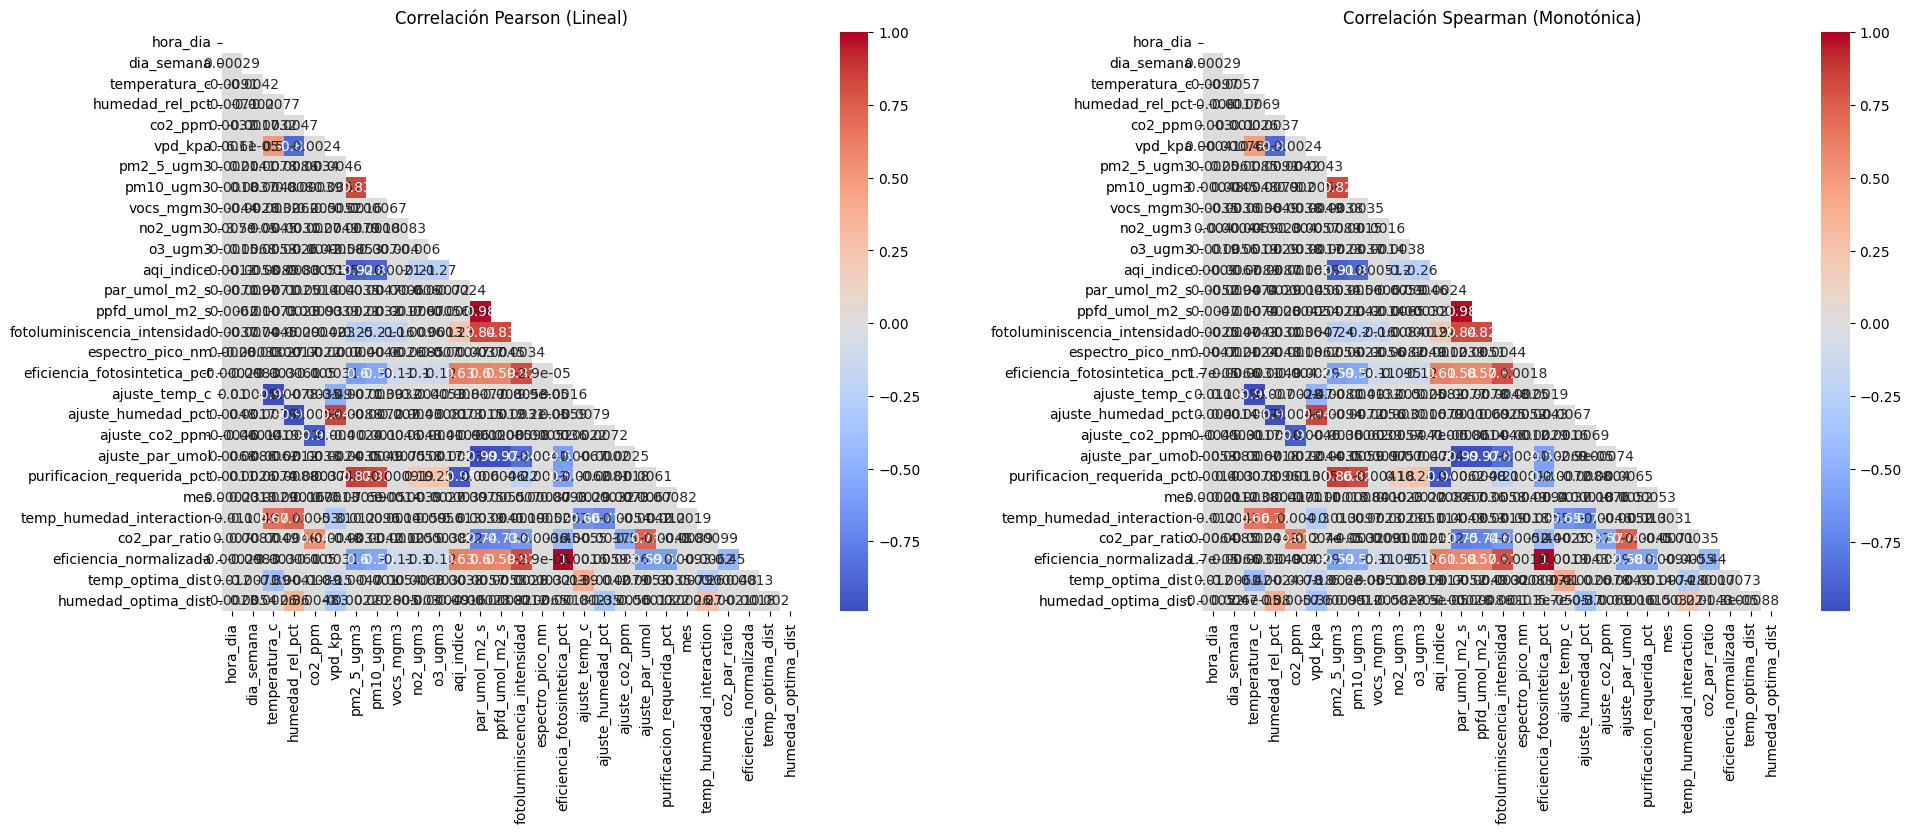


CORRELACIONES MAS FUERTES CON TARGETS:

EFICIENCIA_FOTOSINTETICA_PCT:
  Pearson (Top 5):
    eficiencia_normalizada: 1.000
    fotoluminiscencia_intensidad: 0.821
    aqi_indice: 0.626
    pm2_5_ugm3: 0.602

FOTOLUMINISCENCIA_INTENSIDAD:
  Pearson (Top 5):
    par_umol_m2_s: 0.844
    ajuste_par_umol: 0.835
    ppfd_umol_m2_s: 0.830
    eficiencia_normalizada: 0.821


In [5]:
# ============================================================================
# 2. ANÁLISIS DE CORRELACIONES AVANZADO
# ============================================================================

print("\n2. ANALISIS DE CORRELACIONES AVANZADO...")

def advanced_correlation_analysis(df):
    """Análisis avanzado de correlaciones"""

    # Variables numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Correlación Pearson (lineal)
    corr_pearson = df[numeric_cols].corr()

    # Correlación Spearman (monotónica)
    corr_spearman = df[numeric_cols].corr(method='spearman')

    # Visualizar correlaciones
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Pearson
    mask = np.triu(np.ones_like(corr_pearson, dtype=bool))
    sns.heatmap(corr_pearson, mask=mask, annot=True, cmap='coolwarm',
                center=0, square=True, ax=axes[0])
    axes[0].set_title('Correlación Pearson (Lineal)')

    # Spearman
    mask = np.triu(np.ones_like(corr_spearman, dtype=bool))
    sns.heatmap(corr_spearman, mask=mask, annot=True, cmap='coolwarm',
                center=0, square=True, ax=axes[1])
    axes[1].set_title('Correlación Spearman (Monotónica)')

    plt.tight_layout()
    plt.show()

    # Identificar correlaciones fuertes con targets
    target_cols = ['eficiencia_fotosintetica_pct', 'fotoluminiscencia_intensidad']

    correlations_summary = {}
    for target in target_cols:
        if target in df.columns:
            pearson_corr = df[numeric_cols].corrwith(df[target]).abs().sort_values(ascending=False)
            spearman_corr = df[numeric_cols].corrwith(df[target], method='spearman').abs().sort_values(ascending=False)

            correlations_summary[target] = {
                'pearson': pearson_corr.head(10).to_dict(),
                'spearman': spearman_corr.head(10).to_dict()
            }

    return corr_pearson, corr_spearman, correlations_summary

corr_pearson, corr_spearman, correlations_summary = advanced_correlation_analysis(df)

# Mostrar correlaciones más fuertes
print("\nCORRELACIONES MAS FUERTES CON TARGETS:")
for target, corrs in correlations_summary.items():
    print(f"\n{target.upper()}:")
    print("  Pearson (Top 5):")
    for var, corr in list(corrs['pearson'].items())[:5]:
        if var != target:
            print(f"    {var}: {corr:.3f}")
